Calculated energy kcal/mol:  0.0
Selected step from trajectory:  8


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

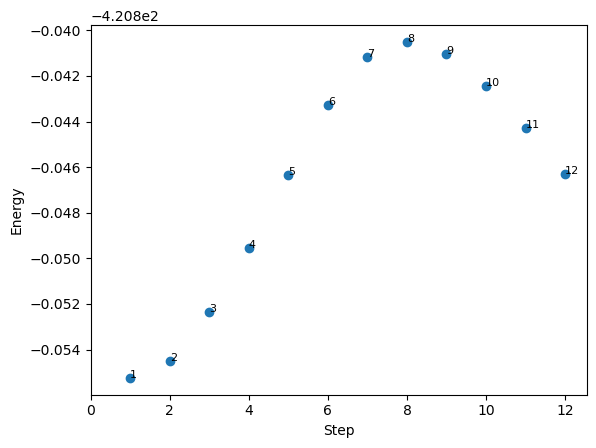

In [7]:
from pathlib import Path
import sys
import sqlite3
import pandas as pd
import ast
from IPython.display import clear_output

sys.path.insert(0, str(Path.cwd().parent))
from util.py3 import from_xyz_block, visualize_traj
from util.sql import refresh
from util.mpl import visualize_scan_energy

refresh()

db = Path.home() / "C5O-Kinetics/db/data.db"
conn = sqlite3.connect(db)

smiles_text = str(input("Enter a SMILES string: ")).upper().strip()

df_smiles = pd.read_sql_query(
    "SELECT * FROM smiles WHERE smiles_text = ?", conn, params=(smiles_text,)
)
df_methods = pd.read_sql_query("SELECT * FROM methods", conn)

smiles_id = df_smiles["smiles_id"].iloc[0]

df_calculations = pd.read_sql_query(
    f"SELECT * FROM calculations WHERE smiles_id = {smiles_id}", conn
)

def prompt_methods(mask):
    methods_dict = {
        int(
            row.method_id
        ): f"  {row.method_id:<10} | {row.method:<15} | {row.functional} {row.basis}"
        for row in df_methods[mask].itertuples()
    }

    print("\n  Select an Available Method: ")
    print("  " + "=" * 55)
    for val in methods_dict.values():
        print(val)

    while True:
        sel_id = int(input("\nSelect a method id: "))
        if sel_id in list(methods_dict.keys()):
            return df_methods[df_methods.method_id == sel_id]



clear_output()
print("\n  Select A Method To Query: ")
sel_method = prompt_methods(df_methods.method_id.isin(df_calculations.method_id))

clear_output()
calcs_dict = {
    row.calc_id: f"  {row.calc_id:<10} | {row.scan_idx1:<2} to {row.scan_idx2:<2}"
    for row in df_calculations[
        df_calculations.method_id == int(sel_method.iloc[0]["method_id"])
    ].itertuples()
}

if len(calcs_dict) > 1:
    print(
        "\n  Multiple Matching Calculations. Select A Calculation To Use As Starting Structure"
    )
    print("  " + "=" * 55)
    for val in calcs_dict.values():
        print(val)
    while True:
        calc_id = int(input("\nSelect a calculation id: "))
        if calc_id in list(calcs_dict.keys()):
            break
else:
    calc_id = list(calcs_dict.keys())[0]

clear_output()
df_energy = pd.read_sql_query(
        "SELECT * FROM energies WHERE calc_id = ?", conn, params=(calc_id,)
    )
df_xyzs = pd.read_sql_query(
    "SELECT * FROM xyz WHERE calc_id = ?", conn, params=(calc_id,)
)

print("Calculated energy kcal/mol: ", df_energy.iloc[0]["energy_value"])

print("Selected step from trajectory: ", df_xyzs.iloc[0]["selected_step"])
initial_xyz = df_xyzs.iloc[0]["xyz_text"]
from_xyz_block(initial_xyz)

if "OPTTS" in sel_method.iloc[0]["method"]:
    df_imag = pd.read_sql_query(
        "SELECT * FROM imaginaryfrequencies WHERE calc_id = ?", conn, params=(calc_id,)
    )
    imag_freq = df_imag.iloc[0]["xyz"]
    visualize_traj(imag_freq)

if "SCAN" in sel_method.iloc[0]["method"]:
    df_traj = pd.read_sql_query(
        "SELECT * FROM traj WHERE calc_id = ?", conn, params=(calc_id,)
    )
    traj = df_traj.iloc[0]["traj_text"]
    visualize_traj(traj)
    arr = ast.literal_eval(df_energy.iloc[0]["energy_array"])
    steps, energies = arr
    visualize_scan_energy(steps, energies)